# Modelling


## Imports & Reading in Data

In [76]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.stats as ss
import seaborn as sns
from sklearn.model_selection import (RandomizedSearchCV,
                                     GridSearchCV)
from sklearn.ensemble import (VotingClassifier,
                              AdaBoostClassifier,
                              RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.linear_model import (LogisticRegression,
                                  SGDClassifier)
from sklearn.metrics import (accuracy_score,
                             f1_score, 
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             classification_report,
                             roc_curve)

%matplotlib inline

In [44]:
X_train = pd.read_csv('Data/Processed/X_train.csv')
X_test = pd.read_csv('Data/Processed/X_test.csv')
y_train = pd.read_csv('Data/Processed/y_train.csv', squeeze=True)
y_test = pd.read_csv('Data/Processed/y_test.csv', squeeze=True)

# Model Training & Hyperparameter Optimization

Several models are trained using `RandomizedSearchCV` and `GridSearchCV`. I use 5-fold cross validation to select the combination of hyperparameters that maximizes accuracy on the out-of-fold prediction. The following models are used:
- Ridge Regression
- Stochastic Gradient Descent (SGD) Classifier
- Random Forest Classifier
- Adaboost Classifier using Decision Trees with a depth of 1
- Hardvoting Classifier
- Softvoting Classifier

If a hospital were to use a similair model in a production setting, they may optimize for precision or recall depending on the weight they put on false negatives or positives.

Logistic regression with lasso regularization was also used, but had trouble converging in a reasonable amount of time (<5 minutes). 

In [45]:
metric = 'accuracy'

scores = {} # create empty dict to store models and cross validation best scores

def results(estimator_name, estimator):
    """
    1. Adds fitted model name, fitted model.best_estimator_ and .best_score_ from RandomizedSearchCV to 
    scores, a nested dictionary.
    """
    bp = estimator.best_params_
    eb = estimator.best_estimator_
    es = estimator.best_score_
    
    scores[estimator_name] = {}
    scores[estimator_name][eb] = es
    
    return print(f'Best params: {bp} \n\nBest score: {es*100}%')

## Logistic Regression with Ridge Regularization

In [46]:
p = {'C':np.arange(1, 16, 1),
     'solver':['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':[None, 'balanced']}
ridge = RandomizedSearchCV(LogisticRegression(penalty='l2',
                                              max_iter=2000),
                           param_distributions=p,
                           n_jobs=-1,
                           cv=5,
                           verbose=1,
                           scoring=metric)
ridge.fit(X_train, y_train.ravel())
results('ridge', ridge)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.6min finished


Best params: {'solver': 'sag', 'class_weight': None, 'C': 12} 

Best score: 63.23451335050974%


## Stochastic Gradient Descent (SGD) Classifier

In [47]:
p = {'alpha':np.linspace(0.000001, 1, 5),
     'penalty':['l1', 'l2'],
     'loss':['hinge', 'log', 'squared_loss', 'huber'],
     'epsilon':np.linspace(0.01, 5, 5)}
sgd = RandomizedSearchCV(SGDClassifier(),
                         param_distributions=p,
                         n_jobs=-1,
                         cv=5, 
                         verbose=1,
                         scoring=metric)
sgd.fit(X_train, y_train)
results('SGD', sgd)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished


Best params: {'penalty': 'l2', 'loss': 'huber', 'epsilon': 1.2575, 'alpha': 0.5000005} 

Best score: 62.080952132838775%


## Random Forest

In [48]:
# random forest
p = {'n_estimators':np.linspace(10, 300, 15).astype(int),
     'bootstrap':[True, False],
     'max_depth':[None, 50, 55, 58, 60, 62, 65, 67, 70, 72, 75],
     'min_samples_split':np.linspace(2, 25, 10).astype(int),
     'min_samples_leaf':np.linspace(2, 100, 10).astype(int),
     'max_features':['auto', 'log2']}

randomforest = RandomizedSearchCV(RandomForestClassifier(),
                                  param_distributions=p,
                                  n_jobs=-1,
                                  cv=5,
                                  verbose=1,
                                  scoring=metric)
randomforest.fit(X_train, y_train)
results('random forest', randomforest)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.4s finished


Best params: {'n_estimators': 258, 'min_samples_split': 19, 'min_samples_leaf': 23, 'max_features': 'auto', 'max_depth': 65, 'bootstrap': True} 

Best score: 63.701185189374%


## Ensembles

In [49]:
# adaboost with Decision Trees of depth 1
p = {'n_estimators':np.arange(20, 150, 2),
     'learning_rate':np.linspace(0.1, 1, 20)}

adb = RandomizedSearchCV(AdaBoostClassifier(),
                         param_distributions=p,
                         cv=5,
                         verbose=1,
                         n_jobs=-1,
                         scoring=metric)
adb.fit(X_train, y_train)
results('adaboost', adb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.2s finished


Best params: {'n_estimators': 120, 'learning_rate': 0.6210526315789474} 

Best score: 63.49668663920085%


In [70]:
# hardvoting
model_scores=[]

for c in [randomforest, adb, ridge, sgd]:
    model_scores.append(c.best_score_)
model_scores = ss.rankdata(model_scores).astype(int)

p = {'weights':[None, model_scores]}
hardvoting = GridSearchCV(VotingClassifier(estimators=[('randomforestclf', randomforest.best_estimator_),
                                                       ('adaboostclf', adb.best_estimator_),
                                                       ('ridgeclf', ridge.best_estimator_),
                                                       ('sgdclf', sgd.best_estimator_)],
                                           voting='hard'),
                          param_grid=p,
                          n_jobs=-1,
                          cv=5,
                          verbose=1,
                          scoring=metric)
hardvoting.fit(X_train, y_train)
results('hardvoting', hardvoting)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Best params: {'weights': array([4, 3, 2, 1])} 

Best score: 63.5438810328564%


In [71]:
# softvoting
model_scores = []
for c in [randomforest, adb, ridge]:
    model_scores.append(c.best_score_)
model_scores = ss.rankdata(model_scores).astype(int)

p = {'weights':[None, model_scores]}
softvoting = GridSearchCV(VotingClassifier(estimators=[('randomforestclf', randomforest.best_estimator_),
                                                       ('adaboostclf', adb.best_estimator_),
                                                       ('ridgeclf', ridge.best_estimator_)],
                                           voting='soft'),
                          param_grid=p,
                          n_jobs=-1,
                          cv=5,
                          verbose=1,
                          scoring=metric)
softvoting.fit(X_train, y_train)
results('softvoting', softvoting)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished


Best params: {'weights': array([3, 2, 1])} 

Best score: 63.65049948596513%


In [84]:
file = open("Models.csv", "w")

writer = csv.writer(file)
for key, value in scores.items():
    writer.writerow([key, value])

file.close()

## Out of Fold Prediction Performance

The following is the accuracy of the best out of fold prediction for each estimator. As can be seen below, the out of fold prediction accuracy and test set prediction accuracy in the Results section is very close, indicating that the models are not overfitting. 

Overfitting would be unlikely considering cross-validation was used with 5 folds.

In [72]:
print('Cross Validation Results')
for k, v in scores.items():
    for k_, v_ in scores[k].items():
        print(f'{k}: {v_*100:.8f}%')

Cross Validation Results
ridge: 63.23451335%
SGD: 62.08095213%
random forest: 63.70118519%
adaboost: 63.49668664%
hardvoting: 63.54388103%
softvoting: 63.65049949%


# Results

Below is the baseline accuracy - a model outputting all 0's would achieve accuracy of 91.31%. 

The models no variance in readmission and perform as well as a model predicting only 0's (no readmission). 

In [73]:
baseline_accuracy = y_test.value_counts()[0]/(y_test.value_counts()[1] + y_test.value_counts()[0]) * 100
baseline_accuracy

59.85738255033557

In [74]:
for k, v in scores.items():
    for k_, v_ in scores[k].items():
        accuracy = accuracy_score(y_true=y_test,
                                  y_pred=k_.predict(X_test))*100
        report = classification_report(y_true=y_test,
                                       y_pred=k_.predict(X_test),
                                       zero_division=0)
        print(f'Model: {k} \nAccuracy: {accuracy:.8f}% \n{report}')
        if accuracy > baseline_accuracy:
            print(f'Better than baseline.\nAbove baseline: {(accuracy - baseline_accuracy)}.\n\n')
        else:
            print(f'Worse than baseline.\nBelow baseline: {(baseline_accuracy - accuracy)}.\n\n')

Model: ridge 
Accuracy: 63.12919463% 
              precision    recall  f1-score   support

           0       0.64      0.89      0.74      8562
           1       0.60      0.25      0.35      5742

    accuracy                           0.63     14304
   macro avg       0.62      0.57      0.55     14304
weighted avg       0.62      0.63      0.59     14304

Better than baseline.
Above baseline: 3.271812080536918.


Model: SGD 
Accuracy: 61.90576063% 
              precision    recall  f1-score   support

           0       0.62      0.96      0.75      8562
           1       0.65      0.11      0.19      5742

    accuracy                           0.62     14304
   macro avg       0.63      0.54      0.47     14304
weighted avg       0.63      0.62      0.53     14304

Better than baseline.
Above baseline: 2.04837807606264.


Model: random forest 
Accuracy: 63.21308725% 
              precision    recall  f1-score   support

           0       0.64      0.89      0.74      8562


Below are ROC curves for each model - the dotted line represents a totally random model, and so curves farther away from the model are better. 

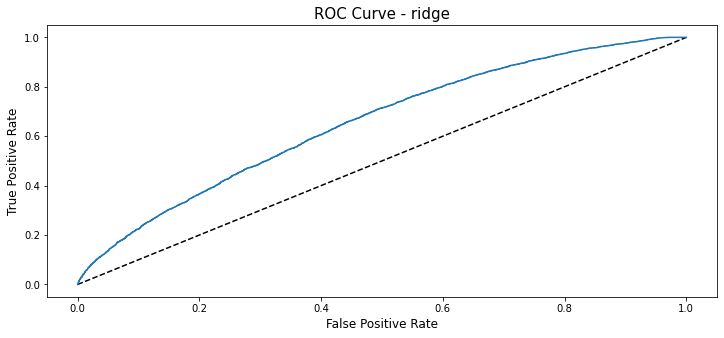

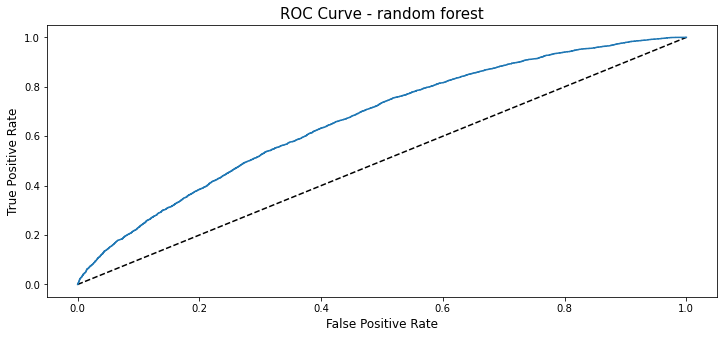

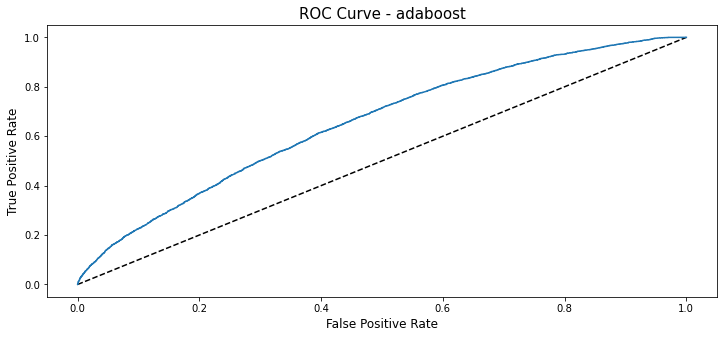

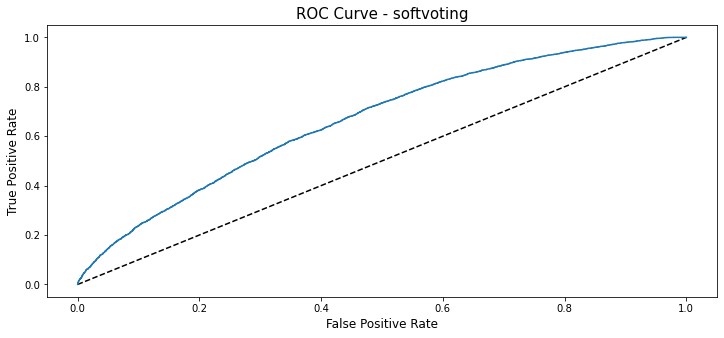

In [93]:
def plot_roc(mod, attribute, X_test=X_test, y_test=y_test):
    """
    Disclaimer: This function is an adaptation from code written by Paul Schrimpf, Thomas Sargent, 
    Quentin Batista, and Natasha Watkins, taken from datascience.quantecon.org. 
    """
    # predicted_probs is an N x 2 array, where N is number of observations
    # and 2 is number of classes
    predicted_probs = mod.predict_proba(X_test)

    # keep the second column, for label=1
    predicted_prob1 = predicted_probs[:, 1]

    fpr, tpr, _ = roc_curve(y_test, predicted_prob1)

    # Plot ROC curve
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate", size=12)
    ax.set_ylabel("True Positive Rate", size=12)
    ax.set_title(f"ROC Curve - {attribute}", size=15)
    plt.savefig(f"Images/ROC_{attribute}.png")

for k, v in scores.items():
    for k_, v_ in scores[k].items():
        if k=='SGD' or k=='hardvoting': # probability methods not available for huber loss function or 
            continue                    # for hardvoting classifier
        else:
            plot_roc(mod=k_, attribute=k)

# Conclusion

The models perform roughly the same in predicting hospital readmission. 
